In [69]:
import jax.numpy as jnp
from jax import random, jit
import matplotlib.pyplot as plt
import numpy as np
from time import time
from jax.scipy.fft import dct, idct

RNG = random.PRNGKey(0)

# Provided decomposition functions (with slight modifications for key parameter passing)

def decomposition_vectorize(X, max_iter=500, tol=1e-6, key=RNG):
    # Reshape X into a vector
    x = X.reshape(-1)

    n = len(x)
    matrix = random.normal(key, (n, n))
    Q, _ = jnp.linalg.qr(matrix)
    u, v_ = jnp.zeros(n), jnp.zeros(n)
    
    x_init = x.copy()

    def projection(x, y):
        # projection of x on y
        return (x.T@y/jnp.linalg.norm(y)**2)*y

    iter = 0
    while iter < max_iter:
        y = Q.T @ x
        if (jnp.linalg.norm(x, 1) > jnp.linalg.norm(y,1)):
            proj = projection(x, jnp.sign(x))
            u += proj
            x -= proj
        else:
            proj = projection(x, Q @ jnp.sign(y))
            v_ += proj
            x -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - u - v_)
        if residual < tol:
            break

        iter += 1

    return x, u, v_, residual, iter


def decomposition_vectorize_dct(X, max_iter=500, tol=1e-6, key=RNG):
    x = X.reshape(-1)
    n = len(x)
    u, v_ = jnp.zeros(n), jnp.zeros(n)
    x_init = x.copy()

    def projection(x, y):
        # projection of x on y
        return (x.T@y/jnp.linalg.norm(y)**2)*y

    iter = 0
    while iter < max_iter:
        y = idct(x, norm="ortho")
        if (jnp.linalg.norm(x, 1) > jnp.linalg.norm(y, 1)):
            proj = projection(x, jnp.sign(x))
            u += proj
            x -= proj
        else:
            proj = projection(x, dct(jnp.sign(y), norm='ortho'))
            v_ += proj
            x -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(x_init - u - v_)
        if residual < tol:
            break

        iter += 1

    return x, u, v_, residual, iter

def decomposition_matrix(X, max_iter=500, tol=1e-6, key=RNG):
    m, n = X.shape
    X_init = X.copy()
    U, V_ = jnp.zeros((m, n)), jnp.zeros((m, n))
    keys = random.split(key, 2)
    Q1, _ = jnp.linalg.qr(random.normal(keys[0], (m, m)))
    Q2, _ = jnp.linalg.qr(random.normal(keys[1], (n, n)))

    def projection(X, Y):
        # projection of X on Y
        return ((X.ravel()).T@Y.ravel()/jnp.linalg.norm(Y)**2)*Y

    iter = 0
    while iter < max_iter:
        Y = Q1.T @ X @ Q2
        if (jnp.linalg.norm(X.ravel(), 1) > jnp.linalg.norm(Y.ravel(), 1)):
            proj = projection(X, jnp.sign(X))
            U += proj
            X -= proj
        else:
            proj = projection(X, Q1 @ jnp.sign(Y) @ Q2.T)
            V_ += proj
            X -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(X_init - U - V_)
        if residual < tol:
            break

        iter += 1

    return X, U, V_, residual, iter, Q1, Q2

def decomposition_matrix_dct(X, max_iter=500, tol=1e-6, key=RNG):
    m, n = X.shape
    X_init = X.copy()
    U, V_ = jnp.zeros((m, n)), jnp.zeros((m, n))

    def projection(X, Y):
        # projection of X on Y
        return ((X.ravel()).T@Y.ravel()/jnp.linalg.norm(Y)**2)*Y

    iter = 0
    while iter < max_iter:
        Y = (idct((idct(X, norm='ortho')).T, norm='ortho')).T
        if (jnp.linalg.norm(X.ravel(), 1) > jnp.linalg.norm(Y.ravel(), 1)):
            proj = projection(X, jnp.sign(X))
            U += proj
            X -= proj
        else:
            proj = projection(X, dct(dct(jnp.sign(Y), norm='ortho').T, norm='ortho').T)
            V_ += proj
            X -= proj

        # Check if termination condition is met
        residual = jnp.linalg.norm(X_init - U - V_)
        if residual < tol:
            break

        iter += 1

    return X, U, V_, residual, iter, "", ""

# Experiment setup
n_values = np.linspace(1000, 3000, num=9, dtype=int)  # Adjust num for more granular analysis
k = 5  # Number of matrices per dimension
methods = [
        # decomposition_vectorize, 
        # decomposition_vectorize_dct, 
        decomposition_matrix, 
        decomposition_matrix_dct
        ]
results = {method.__name__: {'times': [], 'stds': []} for method in methods}

for n in n_values:
    print(f"Processing n = {n}")
    for method in methods:
        times = []
        for _ in range(k):
            RNG = random.PRNGKey(np.random.randint(0, 100))
            X = random.normal(RNG, (n, n))
            X /= jnp.linalg.norm(X, ord="fro")  # Normalizing the matrix
            start_time = time()
            _, __, ___, residual, iter, ____, _____ = method(X, key=RNG)  # Execute decomposition
            times.append(time() - start_time)
            if iter == 500:
                print(f"🤖 Reached the limit with error {residual:.3f}")
        avg_time = np.mean(times)
        std_time = np.std(times)
        results[method.__name__]['times'].append(avg_time)
        results[method.__name__]['stds'].append(std_time)

Processing n = 1000
Processing n = 1250
Processing n = 1500
Processing n = 1750
Processing n = 2000
Processing n = 2250
Processing n = 2500
Processing n = 2750
Processing n = 3000


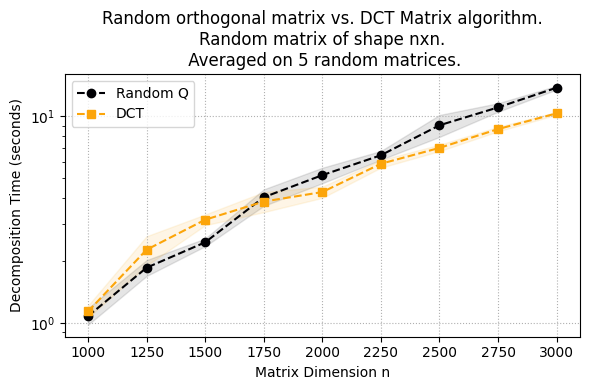

In [70]:
plt.figure(figsize=(6, 4))

# Colormap for different methods and marker styles
colors = plt.cm.inferno(np.linspace(0, 0.8, len(methods)))
markers = ['o', 's', '^', 'D']  # Example markers for four methods
labels = dict.fromkeys(methods)
labels[decomposition_matrix] = "Random Q"
labels[decomposition_matrix_dct] = "DCT"

for i, (method, (color, data)) in enumerate(zip(methods, zip(colors, results.values()))):
    times = data['times']
    stds = data['stds']
    # Plot with dashed line and unique marker for each method
    plt.semilogy(n_values, times, '--', color=color, marker=markers[i], label=labels[method])
    plt.fill_between(n_values, [max(1e-2/2, t - s) for t, s in zip(times, stds)], [t + s for t, s in zip(times, stds)], color=color, alpha=0.1)

plt.xlabel('Matrix Dimension n')
plt.ylabel('Decomposition Time (seconds)')
plt.title(f'Random orthogonal matrix vs. DCT Matrix algorithm.\nRandom matrix of shape nxn.\n Averaged on {k} random matrices.')
plt.legend()
plt.grid(linestyle=":")
plt.tight_layout()
plt.savefig("matrix_vs_vector.pdf")
plt.show()

In [62]:
data['times']

[0.1476567132132394,
 0.20758952413286483,
 0.26021599769592285,
 0.36027114731924875,
 0.5444519519805908,
 0.7725272178649902,
 0.9936121872493199,
 1.3148345606667655,
 1.564296109335763,
 1.7873191492898124,
 2.180670670100621,
 2.68889958517892,
 2.696641274860927,
 3.2806806223733083,
 3.3204870905194963,
 4.4065141677856445,
 4.943220513207572,
 5.344534908022199,
 6.009627137865339,
 6.529519012996128,
 137.9256307056972,
 7.969705377306257,
 8.126507656914848,
 9.825129440852574,
 10.071911130632673]